# Imports

In [84]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import itertools
import time
from sklearn.manifold import TSNE

plt.rcParams['image.cmap'] = 'gray'

resolution = '5.1.13.tiff'
ariel = '5.1.10.tiff'
airplane = '5.1.11.tiff'
APC = '7.1.08.tiff'
left = 'left.png'
right = 'right.png'
splash = '4.2.01.tiff'
jelly_beans = '4.1.08.tiff'
house = '4.1.05.tiff'

# Functions from Assignment 1

## Normalised Histogram

In [3]:
def normHistogram(fileName):
  I = mpimg.imread(fileName)
  if fileName == "left.png" or fileName == "right.png":
    I = I * 255
  frequencies = np.zeros(256)

  for i in range(256):
    frequencies[i] = np.count_nonzero(I == i)

  pixels = np.ones(I.shape).sum()
  normHist = frequencies / pixels

  return normHist

## Entropy

In [4]:
def Entropy(PMF):
  if round(PMF.sum()) != 1:
    return "Invalid"
  
  non_zero_p = PMF[np.where(PMF != 0)]
  results = non_zero_p * np.log2(non_zero_p)
  results = -1 * results.sum()

  return results

## KL Divergence

In [113]:
def KL(p, q):
  nonzeros = np.where(q != 0)
  p = p[nonzeros]
  q = q[nonzeros]

  nonzeros = np.where(p != 0)
  p = p[nonzeros]
  q = q[nonzeros]

  likelihoods = p / q
  likelihoods = np.log2(likelihoods)
  D = (p * likelihoods).sum()
  return D

## Bern

In [7]:
def Bern(p):
  return np.array([1 - p, p])

# Question 1: Distance between PDFs

## (a) Cross Entropy

In [8]:
def CE(p, q):
  return Entropy(p) + KL(p, q)

### i.

In [9]:
leftImg = normHistogram(left)
rightImg = normHistogram(right)
crossEntropy = CE(leftImg, rightImg)
print("Cross entropy of the left and the right images is: ", crossEntropy)

Cross entropy of the left and the right images is:  7.273398119987326


### ii.

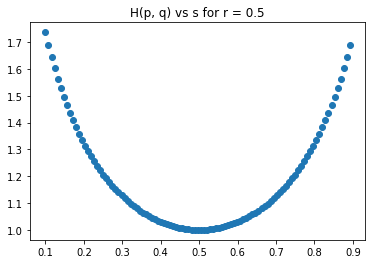

The lowest entropy is obtained when s = 0.5 which is when s = r.


In [58]:
r = 0.5
s = np.linspace(0.1, 0.9, 101, endpoint=False)

p = Bern(r)
H_pq = np.zeros(s.shape)

for i in range(s.shape[0]):
  q = Bern(s[i])
  H_pq[i] = CE(p, q)

plt.scatter(s, H_pq)
plt.title("H(p, q) vs s for r = " + str(r))
plt.show()

print("The lowest entropy is obtained when s = 0.5 which is when s = r.")


## (b) Jensen Shannon

In [52]:
def JS(p, q):
  m = (p + q) / 2
  return KL(p, m) + KL(q, m)

In [56]:
js_lr = JS(leftImg, rightImg)
print("JS(left, right): ", js_lr)

js_rl = JS(rightImg, leftImg)
print("JS(right, left): ", js_rl)

D_lr = KL(leftImg, rightImg)
print("D(left||right): ", D_lr)

D_rl = KL(rightImg, leftImg)
print("D(right||left): ", D_rl)

JS(left, right):  0.0073460795386296575
JS(right, left):  0.0073460795386296575
D(left||right):  0.015104015237387055
D(right||left):  0.01440978583335448


## (c) Wasserstein Distance

# Question 2: Visualizing Data Using t-SNE

## (a)

### i.
The crowding problem referes to the issue thatreducing the dimensionality of sparsely-spaced points from higher dimensions to two dimensions might not be able to accurately capture the distances between them and all the points may end up crowding one section in a 2D space since the 2D space is not nearly large enough to accomodate equidistant points.

### ii.
The Student t-distribution makes joint probabilities of all map scales the same. This means that large point clusters behave similarly to individual points and hence than can be optimised in the same way.

### iii.
1. Simpler gradients
2. Symmetrical conditional probabilities


## (b)

In [117]:
def p_ij(i, j, X, sigma=0.01):
  x_i = X[i]
  x_j = X[j]
  N = np.exp((-np.linalg.norm(x_i - x_j) ** 2) / (2 * (sigma)))
  # N = np.exp((-np.linalg.norm(x_i - x_j) ** 2)) / (2 * (sigma))

  sum = 0
  for k in range(len(X)):
    if i != k:
      x_k = X[k]
      sum += np.exp((-np.linalg.norm(x_i - x_k) ** 2) / (2 * (sigma)))
      # sum += np.exp((-np.linalg.norm(x_i - x_k) ** 2)) / (2 * (sigma))
  return N/sum

def q_ij(i, j, Y):
  y_i = Y[i]
  y_j = Y[j]
  N = np.power(1 + (np.linalg.norm(y_i - y_j) ** 2), -1)

  sum = 0
  for k in range(len(Y)):
    for l in range(len(Y)):
      if l != k:
        y_k = Y[k]
        y_l = Y[l]
        sum += np.power(1 + (np.linalg.norm(y_k - y_l) ** 2), -1)

  return N/sum

In [118]:
def tsne(eta, alpha, T=50, Perp=0.01):

  mu1 = np.ones(10)
  mu2 = 10 * np.ones(10)
  covariance = 0.01 * np.identity(10)

  points = 20

  cluster1 = np.random.multivariate_normal(mu1, covariance, int(points/2))
  cluster2 = np.random.multivariate_normal(mu2, covariance, int(points/2))

  X = np.vstack((cluster1, cluster2))

  P = np.zeros((points, points))
  for i in range(points):
    for j in range(points):
      if i != j:
        P[i, j] = (p_ij(i, j, X) + p_ij(j, i, X)) / (2 * points)

  Y = np.random.multivariate_normal([0, 0], 0.0001 * np.identity(2), points)
  Y_0 = Y.copy()

  Q = np.zeros((points, points))
  for i in range(points):
    for j in range(points):
      if i != j:
        Q[i, j] = q_ij(i, j, Y)
  
  Q_0 = Q.copy()
  
  gradient = np.zeros(Y.shape)
  for t in range(T):
    # calculating gradient
    for i in range(len(Y)):
      for j in range(len(Y)):
        temp = 4 * (P[i, j] - Q[i, j]) * (Y[i] - Y[j]) * np.power(1 + (-np.linalg.norm(Y[i] - Y[j]) ** 2), -1)
        gradient[i] += 4 * (P[i, j] - Q[i, j]) * (Y[i] - Y[j]) * np.power(1 + (np.linalg.norm(Y[i] - Y[j]) ** 2), -1)
    
    if t == 0:
      prev_Y = Y.copy()
      Y = Y + eta * gradient + alpha * Y
    else:
      Y = Y + eta * gradient + alpha * (Y - prev_Y)
      prev_Y = Y.copy()

    # update Q
    for i in range(points):
      for j in range(points):
        if i != j:
          Q[i, j] = q_ij(i, j, Y)

  return Y_0, Y, Q_0, Q, P

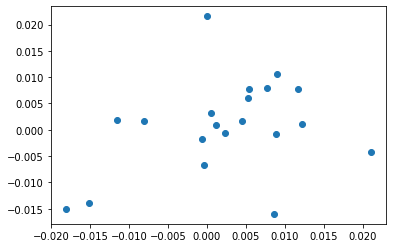

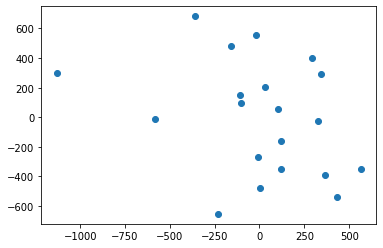

In [119]:
Y_init, Y_final, Q_init, Q_final, P = tsne(50, 0.2)

plt.scatter(Y_init[:, 0], Y_init[:, 1])
plt.show()

plt.scatter(Y_final[:, 0], Y_final[:, 1])
plt.show()

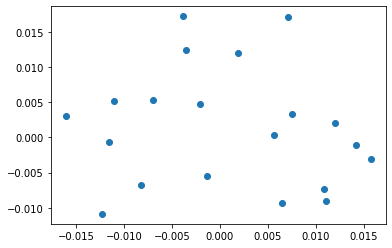

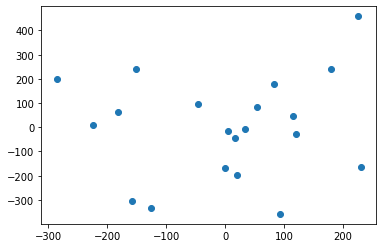

In [120]:
Y_init, Y_final, Q_init, Q_final, P = tsne(20, 0.2)

plt.scatter(Y_init[:, 0], Y_init[:, 1])
plt.show()

plt.scatter(Y_final[:, 0], Y_final[:, 1])
plt.show()

In [121]:
print("D(P || Q_initial)", KL(P, Q_final))
print("D(P || Q_final)", KL(P, Q_init))

D(P || Q_initial) 5.214416922833328
D(P || Q_final) 2.6374831911757717


## (c)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


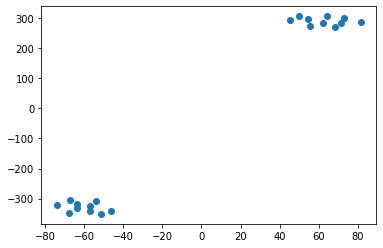

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


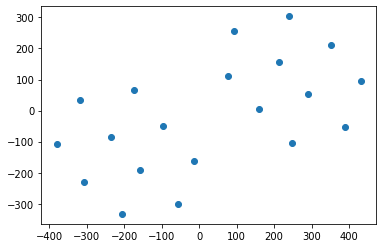

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


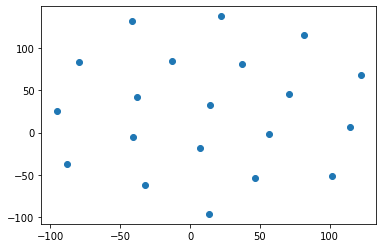

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


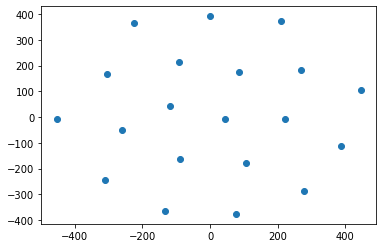

In [92]:
mu1 = np.ones(10)
mu2 = 10 * np.ones(10)
covariance = 0.01 * np.identity(10)
points = 20
cluster1 = np.random.multivariate_normal(mu1, covariance, int(points/2))
cluster2 = np.random.multivariate_normal(mu2, covariance, int(points/2))
X = np.vstack((cluster1, cluster2))

Y = TSNE(perplexity=5).fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1])
plt.show()

Y = TSNE(perplexity=15).fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1])
plt.show()

Y = TSNE(perplexity=25).fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1])
plt.show()

Y = TSNE(perplexity=35).fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1])
plt.show()

In [93]:
print("As the perplexity increases, the clustering reduces.")

As the perplexity increases, the clustering reduces.


# Question 3: Convolution and Correlation

In [19]:
def randomKernel(kernel_size):
  M = np.random.rand(kernel_size, kernel_size)
  kernel = [M, M, M]
  kernel = np.array(kernel)
  return kernel

## (a) Convolution

In [83]:
def convolution(I, kernel):

  W, H, C = I.shape
  k, _, C = kernel.shape

  kernel = np.flipud(np.fliplr(kernel))

  result = np.zeros((W, H))

  # zero padding
  padding = k // 2
  # padding = k - 1
  npad = ((k - 1, k - 1), (k - 1, k - 1), (0, 0))
  # npad = k - 1
  padded = np.pad(I, pad_width=npad, mode='reflect',  reflect_type='even')
  

  for i in range(padding, W + padding):
    for j in range(padding, H + padding):
      result[i - padding, j - padding] = (np.multiply(kernel, padded[i - padding: i + padding + 1, j - padding: j + padding + 1, :]).sum())

  result = result / kernel.sum()
  result = result.astype(int)
  return result

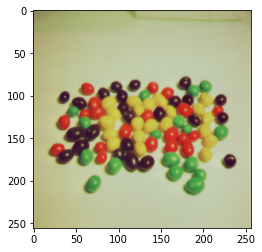

In [80]:
jelly = mpimg.imread(jelly_beans)
plt.imshow(jelly)

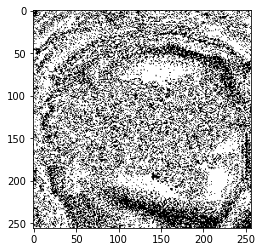

In [81]:
kernel = jelly[:3, :3, :].copy()
conv = convolution(jelly, kernel)
plt.imshow(conv)

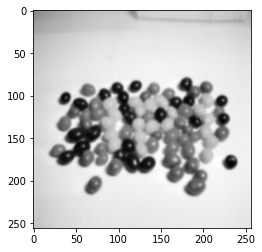

In [82]:
conv = convolution(jelly, randomKernel(3))
plt.imshow(conv)

## (b) Correlation

In [26]:
def correlation(I, kernel):

  W, H, C = I.shape
  k, _, C = kernel.shape

  result = np.zeros((W, H))

  # zero padding
  padding = k // 2
  # padding = k - 1
  npad = ((k - 1, k - 1), (k - 1, k - 1), (0, 0))
  # npad = k - 1
  padded = np.pad(I, pad_width=npad, mode='reflect',  reflect_type='even')
  

  for i in range(padding, W + padding):
    for j in range(padding, H + padding):
      result[i - padding, j - padding] = (np.multiply(kernel, padded[i - padding: i + padding + 1, j - padding: j + padding + 1, :]).sum())

  result = result / kernel.sum()
  result = result.astype(int)
  return result

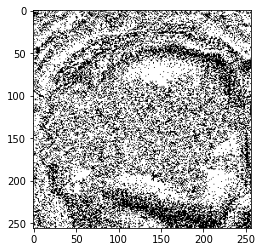

In [27]:
kernel = jelly[:3, :3, :].copy()
conv = correlation(jelly, kernel)
plt.imshow(conv)

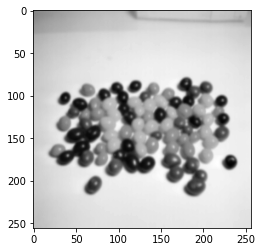

In [60]:
conv = correlation(jelly, randomKernel(3))
plt.imshow(conv)